# CUDA C Best Practices Guide -- Shared Memory Optimisations

Change the following to run the same analysis on a different problem size:

In [26]:
%env OCLGRIND=/oclgrind
%env PROBLEM_SIZE=tiny
#%env PROBLEM_SIZE=small
#%env PROBLEM_SIZE=medium
#%env PROBLEM_SIZE=large

# set-up compulsory stuff
%load_ext rpy2.ipython

env: OCLGRIND=/oclgrind
env: PROBLEM_SIZE=tiny
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Generate runtime data

In [28]:
! make clean
! make

rm -f sbd aiwc-tester lsb.*.r0* aiwc_*.csv aiwc_*_itb.log Rplots.pdf cpu-loop-block cpu-mandelbrot-vectorization
g++ gpu-strided-global-memory-access-unoptimised.cpp -o gpu-stride -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -L/usr/lib/x86_64-linux-gnu/ -lgsl -lgslcblas -std=c++11 
gpu-strided-global-memory-access-unoptimised.cpp:74:49: error: stray '\' in program
         std::cout << x[i] << ((i % dim) ? ' ' : \n);
                                                 ^
gpu-strided-global-memory-access-unoptimised.cpp: In function 'void print_payload(float*, unsigned int)':
gpu-strided-global-memory-access-unoptimised.cpp:74:50: error: 'n' was not declared in this scope
         std::cout << x[i] << ((i % dim) ? ' ' : \n);
                                                  ^
Makefile:4: recipe for target 'gpu-stride' failed
make: *** [gpu-stride] Error 1


Run the experiment and collect runtime data

In [22]:
! cat ./gpu-strided-global-memory-access-unoptimised.cl

//shared memory in matrix multiplication ported from the [cuda c best practices guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#shared-memory-in-matrix-multiplication-c-aa)

__kernel void simpleMultiply(__global float *a,__global float *b,__global float *c, int N)
{
    int row = get_group_id(1) * get_local_size(1) + get_local_id(1);//blockIdx.y * blockDim.y + threadIdx.y;
    int col = get_group_id(0) * get_local_size(0) + get_local_id(0);//blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0f;
    for (int i = 0; i < TILE_DIM; i++) {
        sum += a[row*TILE_DIM+i] * b[i*N+col];
    }
    c[row*TILE_DIM+col] = sum;
}

__kernel void coalescedMultiply(__global float* a, __global float* b, __global float* c, int N)
{
    __local float aTile[TILE_DIM][TILE_DIM];
    int row = get_group_id(1) * get_local_size(1) + get_local_id(1);//blockIdx.y * blockDim.y + threadIdx.y;
    int col = get_group_id(0) * get_local_size(0) + get_local_id(0);//blockIdx.x * blo

In [23]:
! ./gpu-stride ./gpu-strided-global-memory-access-unoptimised.cl $PROBLEM_SIZE 0 0 runtime

***** LSB_Init >gpu_memory_access< writing to >lsb.gpu_memory_access.r0< *****
Attempting kernel: ./gpu-strided-global-memory-access-unoptimised.cl with contents:
//shared memory in matrix multiplication ported from the [cuda c best practices guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#shared-memory-in-matrix-multiplication-c-aa)

__kernel void simpleMultiply(__global float *a,__global float *b,__global float *c, int N)
{
    int row = get_group_id(1) * get_local_size(1) + get_local_id(1);//blockIdx.y * blockDim.y + threadIdx.y;
    int col = get_group_id(0) * get_local_size(0) + get_local_id(0);//blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0f;
    for (int i = 0; i < TILE_DIM; i++) {
        sum += a[row*TILE_DIM+i] * b[i*N+col];
    }
    c[row*TILE_DIM+col] = sum;
}

__kernel void coalescedMultiply(__global float* a, __global float* b, __global float* c, int N)
{
    __local float aTile[TILE_DIM][TILE_DIM];
    int row = get_group_id(1) * 

## Analyse runtimes data -- to ensure the OpenCL port of the cuda codes matches those shown in CUDA code-book

In [10]:
import pandas as pd
x = pd.read_csv('lsb.gpu_memory_access.r0', comment='#', sep="\s+")
print(x)

y = x[(x.region == 'simpleMultiply_kernel') | (x.region == 'coalescedMultiply_kernel') | (x.region == 'sharedABMultiply_kernel')]



     problem_size            kernel                        region  id  \
0            tiny          none_yet               host_side_setup   0   
1            tiny          none_yet               kernel_creation   0   
2            tiny          none_yet      device_side_buffer_setup   0   
3            tiny    simpleMultiply  host_side_initialise_buffers   0   
4            tiny    simpleMultiply          device_side_h2d_copy   0   
5            tiny    simpleMultiply         simpleMultiply_kernel   0   
6            tiny    simpleMultiply          device_side_d2h_copy   0   
7            tiny    simpleMultiply  host_side_initialise_buffers   1   
8            tiny    simpleMultiply          device_side_h2d_copy   1   
9            tiny    simpleMultiply         simpleMultiply_kernel   1   
10           tiny    simpleMultiply          device_side_d2h_copy   1   
11           tiny    simpleMultiply  host_side_initialise_buffers   2   
12           tiny    simpleMultiply          device

The distributions of 100 runtimes for each of the 3 kernels of memory striding for GPU optimisations are shown below.

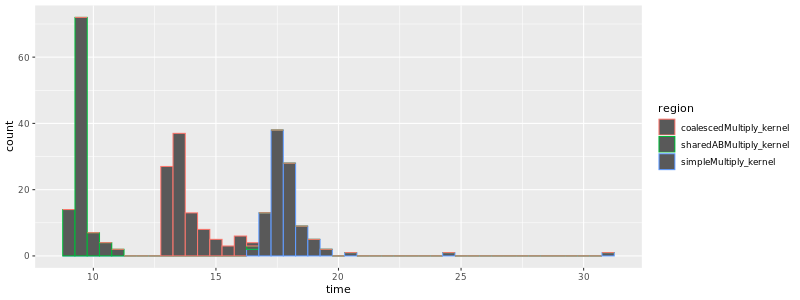

In [11]:
%%R -i y -w 800 -h 300 -u px

library(ggplot2)
pp = ggplot(y, aes_string(x='time', colour = 'region')) + geom_histogram(binwidth=.5)
print(pp)

**NOTE:** Do these distributions appear suspect? Perhaps move the timing regions to outside of the loop and divide by iterations -- in the C host source

In [12]:
z = y.drop(['id','overhead'],axis=1)
z = z.rename(columns={'time':'time (ms)'})
z.groupby(["region"]).median()

,time (ms)
region,
coalescedMultiply_kernel,13.562500
sharedABMultiply_kernel,9.344238
simpleMultiply_kernel,17.724609


## Generate AIWC feature-space per kernel

In [24]:
! make clean
! make
! $OCLGRIND/bin/oclgrind --workload-characterisation ./gpu-stride ./gpu-strided-global-memory-access-unoptimised.cl $PROBLEM_SIZE 0 0 aiwc
! rm -f lsb.*.r0* #we aren't interested in runtime data anymore

rm -f sbd aiwc-tester lsb.*.r0* aiwc_*.csv aiwc_*_itb.log Rplots.pdf cpu-loop-block cpu-mandelbrot-vectorization
g++ cpu-loop-blocking.cpp -o cpu-loop-block -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ cpu-mandelbrot-vectorization.cpp -o cpu-mandelbrot-vectorization -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ aiwc-tester.cpp -o aiwc-tester -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
***** LSB_Init >gpu_memory_access< writing to >lsb.gpu_memory_access.r0< *****
Attempting kernel: ./gpu-strided-global-memory-access-unoptimised.cl with contents:
//shared memory in matrix multiplication ported from the [cuda c best practices guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#shared-memory-in-matrix-multiplication-c-aa)

__kernel void simpleMultiply(__global float *a,__global float *b,__global float *c, int N)
{
    int row = get_group_id(1) * get_local_size(1) + get_local_id(1);//blockIdx

Min data width: 1
Max data width: 1
Operand sum: 2.08896e+06
Mean data width: 1
stdev data width: 0
Granularity: 4.78707e-07
Barriers Per Instruction : 4.78707e-07
Instructions Per Operand : 1
+--------------------------------------------------------------------------+
|Total Memory Footprint -- total number of unique memory addresses accessed|
+==========================================================================+
543268
+----------------------------------------------------------------------------------------------+
|90% Memory Footprint -- Number of unique memory addresses that cover 90% of memory accesses   |
+==============================================================================================+
total number of memory accesses = 281018368
90% of memory accesses:252916532
Number of unique memory addresses that cover 90% of memory accesses: 55170
+----------------------------------------------------------------------------------------------+
|Global Memory Address Entrop

## Analyse AIWC data

First load in new data

In [25]:
import pandas as pd
simpleMultiply = pd.read_csv('aiwc_simpleMultiply_0.csv', sep=",")
coalescedMultiply = pd.read_csv('aiwc_coalescedMultiply_0.csv', sep=",")
sharedABMultiply = pd.read_csv('aiwc_sharedABMultiply_0.csv', sep=",")

Standardise according to existing data -- from the predictive modelling paper

In [11]:
%%R -i simpleMultiply -i coalescedMultiply -i sharedABMultiply -o featdata.all

simpleMultiply$application <- "matrix_multiplication"
simpleMultiply$kernel <- "simple_multiply"
simpleMultiply$invocation <- 0
simpleMultiply$size <- Sys.getenv('PROBLEM_SIZE')

coalescedMultiply$application <- "matrix_multiplication"
coalescedMultiply$kernel <- "coalesced_multiply"
coalescedMultiply$invocation <- 0
coalescedMultiply$size <- Sys.getenv('PROBLEM_SIZE')

sharedABMultiply$application <- "matrix_multiplication"
sharedABMultiply$kernel <- "shared_ab_multiply"
sharedABMultiply$invocation <- 0
sharedABMultiply$size <- Sys.getenv('PROBLEM_SIZE')

featdata.all <- rbind(simpleMultiply,coalescedMultiply)
featdata.all <- rbind(featdata.all,sharedABMultiply)

Studentise the AIWC data

In [23]:
%%R -i featdata.all -o aiwc

source('/opencl-predictions-with-aiwc/codes/restructure_aiwc_data.R')
aiwc <- reorder_features(featdata.all)


Comparison between AIWC feature-spaces

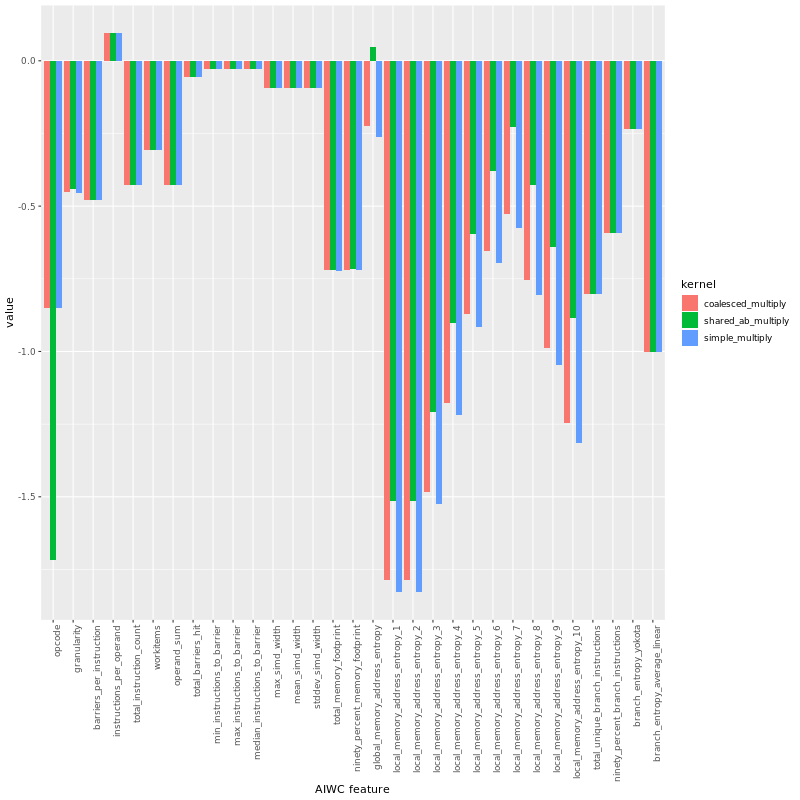

In [19]:
%%R -i aiwc -w 800 -h 800 -u px

options(jupyter.plot_mimetypes = 'image/png')

library(ggplot2)
library(reshape2)

aiwc.of.interest <- subset(aiwc, application == "matrix_multiplication")
aiwc.of.interest = subset(aiwc.of.interest, select = -size)
aiwc.of.interest = subset(aiwc.of.interest, select = -invocation)
aiwc.of.interest = subset(aiwc.of.interest, select = -application)

melted = melt(aiwc.of.interest, id.var = 'kernel')
pdf("test.pdf")
ggplot(melted, aes(x = variable, y = value, fill = kernel)) + geom_bar(stat = "identity", position = 'dodge') +
    scale_x_discrete(name = "AIWC feature") + theme(axis.text.x = element_text(angle = 90, hjust = 1))
dev.off()

#ggsave(sprintf("time_matrixMultiply_%s.png", "large"))#, plot = last_plot(), device = NULL, path = NULL,
  #scale = 1, width = NA, height = NA,
  #dpi = 300, limitsize = TRUE)


In [20]:
# ggsave("time_matrixMultiply_tiny.png")#, plot = last_plot(), device = NULL, path = NULL,
  #scale = 1, width = NA, height = NA,
  #dpi = 300, limitsize = TRUE)

<img src="time_matrixMultiply_large.png" width="2000" alt="Figure . Matrix Multiply Features">


## Prediction Accuracy Of AIWC Metrics

Generate the predictive model

In [17]:
%%R -o model

library(ranger)

load("/opencl-predictions-with-aiwc/data/intermediate/full_dat.Rda")

#manually typecast integer variables
int.inds <- c(2,6,7,8,9,10,11,12,13,16,17,29,30,34,37)

#standardise numeric variables
num.inds <- lapply(full_dat, is.numeric)
num.inds <- as.logical(num.inds)

for (i in seq(along = num.inds)){
            feature.name = names(full_dat[i])
            ifelse((any(i == int.inds) || num.inds[i] == 'FALSE' || feature.name == "kernel_time"), next, full_dat[i] <- scale(full_dat[i]))
                                } #end i loop

#use 20% of data for training
#sampled_indices <- sample(seq_len(nrow(full_dat)), size = round(nrow(full_dat)*0.2))
#train_dat <- full_dat[sampled_indices, ]
#test_dat <- full_dat[-sampled_indices, ]
#or...
#use 100% of data for training
train_dat <- full_dat

#remove certain variables unavailable during real-world training
train_dat = subset(train_dat, select = -size)
train_dat = subset(train_dat, select = -application)
train_dat = subset(train_dat, select = -kernel)
train_dat = subset(train_dat, select = -total_time)

#build the model
rgd.aiwc <- ranger(log(kernel_time)~.,
                   data = train_dat,
                   num.trees = 505,
                   mtry = 30,
                   min.node.size = 9,
                   importance = "impurity",
                   splitrule = 'variance',
                   respect.unordered.factors = 'order')

model <- rgd.aiwc

Make prediction with our AIWC metrics

In [18]:
%%R -i aiwc -i model -o predicted

#manually typecast integer variables
#int.inds <- c(2,6,7,8,9,10,11,12,13,16,17,29,30,34,37)

#standardise numeric variables
#num.inds <- lapply(aiwc, is.numeric)
#num.inds <- as.logical(num.inds)

#for (i in seq(along = num.inds)){
#            feature.name = names(aiwc[i])
#            ifelse((any(i == int.inds) || num.inds[i] == 'FALSE' || feature.name == "kernel_time"), next, aiwc[i] <- scale(aiwc[i]))
#                                } #end i loop
predicted <- data.frame()

x <- subset(aiwc, kernel=="simple_multiply")
x$device = 'gtx1080'
x$run = 0
prediction <- predict(model,type='response',data=x)
print(paste("simple multiply", round(exp(prediction$pred),digits=2), "(ms)"))
predicted <- rbind(predicted, data.frame('region'='simple_multiply','predicted time (ms)'=round(exp(prediction$pred),digits=2)))

x <- subset(aiwc, kernel=="coalesced_multiply")
x$device = 'gtx1080'
x$run = 0
prediction <- predict(model,type='response',data=x)
print(paste("coalesced multiply", round(exp(prediction$pred),digits=2), "(ms)"))
predicted <- rbind(predicted, data.frame('region'='coalesced_multiply','predicted time (ms)'=round(exp(prediction$pred),digits=2)))

x <- subset(aiwc, kernel=="shared_ab_multiply")
x$device = 'gtx1080'
x$run = 0
prediction <- predict(model,type='response',data=x)
print(paste("shared ab multiply", round(exp(prediction$pred),digits=2), "(ms)"))
predicted <- rbind(predicted, data.frame('region'='shared_ab_multiply','predicted time (ms)'=round(exp(prediction$pred),digits=2)))


[1] "simple multiply 96.7 (ms)"
[1] "coalesced multiply 95.71 (ms)"
[1] "shared ab multiply 98.37 (ms)"


Compare predictions against measured times

In [16]:
groundtruth = z
groundtruth = groundtruth.groupby(['region']).mean()

groundtruth = groundtruth.rename({'simpleMultiply_kernel':'simple_multiply',
                                  'coalescedMultiply_kernel':'coalesced_multiply',
                                  'sharedABMultiply_kernel':'shared_ab_multiply'})
comparison = pd.merge(predicted,groundtruth,left_on='region',right_on='region')
comparison.head()

,region,predicted.time..ms.,time (ms)
0,simple_multiply,90.98,540.314893
1,coalesced_multiply,1289.74,290.453984
2,shared_ab_multiply,3941.15,167.844932


**Note:** The predictive accuracy is bad for both the simple and coalesced case -- reasons?

# Loop Blocking Example 4-25 from Intel 64 and IA-32 Architectures Optimization Reference Manual

## Generate runtime data

Run the experiment and collect runtime data

In [17]:
! make clean; make
! ./cpu-loop-block ./cpu-loop-blocking.cl $PROBLEM_SIZE 1 0 runtime

rm -f sbd aiwc-tester lsb.*.r0* aiwc_*.csv aiwc_*_itb.log Rplots.pdf cpu-loop-block cpu-mandelbrot-vectorization
g++ cpu-loop-blocking.cpp -o cpu-loop-block -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ cpu-mandelbrot-vectorization.cpp -o cpu-mandelbrot-vectorization -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ aiwc-tester.cpp -o aiwc-tester -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
***** LSB_Init >cpu_loop_blocking< writing to >lsb.cpu_loop_blocking.r0< *****
Attempting kernel: ./cpu-loop-blocking.cl with contents:
//Loop Blocking Example 4-25 from https://www.intel.com/content/dam/www/public/us/en/documents/manuals/64-ia-32-architectures-optimization-manual.pdf in Section 4.5.3 Loop Blocking
//TODO: verify loop-blocking correctness
__kernel void original_loop(__global float* A, __global float* B)
{
    //get_group_id(0) * get_local_size(0) + get_local_id(0);//not needed -- intel tests only for single threa

## Analyse runtime data

In [18]:
import pandas as pd
x = pd.read_csv('lsb.cpu_loop_blocking.r0', comment='#', sep="\s+")

y = x[(x.region == 'original_loop_kernel') | (x.region == 'transformed_loop_after_blocking_kernel')]



EmptyDataError: No columns to parse from file

The distributions of 100 runtimes for each of the 2 kernels is shown below.

In [ ]:
%%R -i y -w 800 -h 300 -u px

library(ggplot2)
pp = ggplot(y, aes_string(x='time', colour = 'region')) + geom_histogram(binwidth=.1)
print(pp)

In [ ]:
z = y.drop(['id','overhead'],axis=1)
z = z.rename(columns={'time':'time (mins)'})
z.groupby(["region"]).median()*1.66667e-5

## Generate AIWC feature-space per kernel

In [ ]:
! make clean
! make
! $OCLGRIND/bin/oclgrind --workload-characterisation ./cpu-loop-block ./cpu-loop-blocking.cl $PROBLEM_SIZE 0 0 aiwc
! rm -f lsb.*.r0* #we aren't interested in runtime data anymore

## Analyse AIWC data

First load in new data

In [ ]:
import pandas as pd
originalLoop = pd.read_csv('./aiwc_original_loop_0.csv', sep=",")
transformedLoop = pd.read_csv('aiwc_transformed_loop_after_blocking_0.csv', sep=",")

Standardise according to existing data -- from the predictive modelling paper

In [ ]:
%%R -i originalLoop -i transformedLoop -o featdata.all

load('/opencl-predictions-with-aiwc/data/intermediate/featdata.Rda')

originalLoop$application <- "loop_blocking"
originalLoop$kernel <- "original_loop"
originalLoop$invocation <- 0
originalLoop$size <- "tiny"

transformedLoop$application <- "loop_blocking"
transformedLoop$kernel <- "transformed_loop"
transformedLoop$invocation <- 0
transformedLoop$size <- "tiny"

featdata.all <- rbind(featdata.all,originalLoop)
featdata.all <- rbind(featdata.all,transformedLoop)


Studentise the AIWC data

In [ ]:
%%R -i featdata.all -o aiwc

source('/opencl-predictions-with-aiwc/codes/restructure_aiwc_data.R')
pca_dat <- reorder_features(featdata.all)
pca_dat$opcode <- scale(pca_dat$opcode,scale=TRUE)[,1]
pca_dat$granularity <- scale(pca_dat$granularity,scale=TRUE)[,1]
pca_dat$barriers_per_instruction <- scale(pca_dat$barriers_per_instruction,scale=TRUE)[,1]
pca_dat$instructions_per_operand <- scale(pca_dat$instructions_per_operand,scale=TRUE)[,1]
pca_dat$total_instruction_count <- scale(pca_dat$total_instruction_count,scale=TRUE)[,1]
pca_dat$workitems <- scale(pca_dat$workitems,scale=TRUE)[,1]
pca_dat$operand_sum <- scale(pca_dat$operand_sum,scale=TRUE)[,1]
pca_dat$total_barriers_hit <- scale(pca_dat$total_barriers_hit,scale=TRUE)[,1]
pca_dat$min_instructions_to_barrier <- scale(pca_dat$min_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_instructions_to_barrier <- scale(pca_dat$max_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$median_instructions_to_barrier <- scale(pca_dat$median_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_simd_width <- scale(pca_dat$max_simd_width,scale=TRUE)[,1]
pca_dat$mean_simd_width <- scale(pca_dat$mean_simd_width,scale=TRUE)[,1]
pca_dat$stddev_simd_width <- scale(pca_dat$stddev_simd_width,scale=TRUE)[,1]
pca_dat$total_memory_footprint <- scale(pca_dat$total_memory_footprint,scale=TRUE)[,1]
pca_dat$ninety_percent_memory_footprint <- scale(pca_dat$ninety_percent_memory_footprint,scale=TRUE)[,1]
pca_dat$global_memory_address_entropy <- scale(pca_dat$global_memory_address_entropy,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_1 <- scale(pca_dat$local_memory_address_entropy_1,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_2 <- scale(pca_dat$local_memory_address_entropy_2,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_3 <- scale(pca_dat$local_memory_address_entropy_3,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_4 <- scale(pca_dat$local_memory_address_entropy_4,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_5 <- scale(pca_dat$local_memory_address_entropy_5,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_6 <- scale(pca_dat$local_memory_address_entropy_6,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_7 <- scale(pca_dat$local_memory_address_entropy_7,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_8 <- scale(pca_dat$local_memory_address_entropy_8,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_9 <- scale(pca_dat$local_memory_address_entropy_9,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_10 <- scale(pca_dat$local_memory_address_entropy_10,scale=TRUE)[,1]
pca_dat$total_unique_branch_instructions <- scale(pca_dat$total_unique_branch_instructions,scale=TRUE)[,1]
pca_dat$ninety_percent_branch_instructions <- scale(pca_dat$ninety_percent_branch_instructions,scale=TRUE)[,1]
pca_dat$branch_entropy_yokota <- scale(pca_dat$branch_entropy_yokota,scale=TRUE)[,1]
pca_dat$branch_entropy_average_linear <- scale(pca_dat$branch_entropy_average_linear,scale=TRUE)[,1]
aiwc <- pca_dat

Comparison between AIWC feature-spaces

In [ ]:
%%R -i aiwc -w 800 -h 800 -u px

library(ggplot2)
library(reshape2)

aiwc.of.interest <- subset(aiwc, application == "loop_blocking")
aiwc.of.interest = subset(aiwc.of.interest, select = -size)
aiwc.of.interest = subset(aiwc.of.interest, select = -invocation)
aiwc.of.interest = subset(aiwc.of.interest, select = -application)

melted = melt(aiwc.of.interest, id.var = 'kernel')
ggplot(melted, aes(x = variable, y = value, fill = kernel)) + geom_bar(stat = "identity", position = 'dodge') +
    scale_x_discrete(name = "AIWC feature") + theme(axis.text.x = element_text(angle = 90, hjust = 1))


# Vectorization of Mandelbrot Set -- Example 5-33 from Intel 64 and IA-32 Architectures Optimization Reference Manual

This example examines the ability to improve the performance of CPU devices by using vectorisation / Single Instruction Multiple Data (SIMD) level optimization. This is done by first examining the code to produce a Mandelbrot set -- a sample is shown in Figure 1.

<img src="mandelbrot.png" width="200" alt="Figure 1. Mandelbrot set">

<!--
![Figure 1. Mandelbrot set](mandelbrot.png =250x)
-->

The optimization involves restucturing the code to pack four floating point values into the same register allowing 128 bits to be treated in the same instruction. The Intel codebook, from which this example was based, originally targeted SSEv4. However, since this is intel specific an OpenCL alternative was developed. Support for vectorization comes built into OpenCL using vector primatives. 

## Generate runtime data

Run the experiment and collect runtime data

In [ ]:
! make clean; make
! ./cpu-mandelbrot-vectorization ./cpu-mandelbrot-vectorization-set-map.cl $PROBLEM_SIZE 1 0 runtime

## Analyse runtime data

In [ ]:
import pandas as pd
x = pd.read_csv('lsb.cpu_vectorization.r0', comment='#', sep="\s+")

y = x[(x.region == 'mandelbrot_kernel') | (x.region == 'mandelbrot_vectorized_kernel')]



The distributions of 100 runtimes for each of the 2 kernels is shown below.

In [ ]:
%%R -i y -w 800 -h 300 -u px

library(ggplot2)
pp = ggplot(y, aes_string(x='time', colour = 'region')) + geom_histogram(binwidth=.1)
print(pp)

In [ ]:
z = y.drop(['id','overhead'],axis=1)
z = z.rename(columns={'time':'time (ms)'})
z.groupby(["region"]).median()

## Generate AIWC feature-space per kernel

In [ ]:
! make clean
! make
! $OCLGRIND/bin/oclgrind --workload-characterisation ./cpu-mandelbrot-vectorization ./cpu-mandelbrot-vectorization-set-map.cl $PROBLEM_SIZE 0 0 aiwc
! rm -f lsb.*.r0* #we aren't interested in runtime data anymore

## Analyse AIWC data

First load in new data

In [ ]:
import pandas as pd
mandelbrot = pd.read_csv('./aiwc_mandelbrot_0.csv', sep=",")
mandelbrotVectorized = pd.read_csv('./aiwc_mandelbrot_vectorized_0.csv', sep=",")

Standardise according to existing data -- from the predictive modelling paper

In [ ]:
%%R -i mandelbrot -i mandelbrotVectorized -o featdata.all

load('/opencl-predictions-with-aiwc/data/intermediate/featdata.Rda')

mandelbrot$application <- "mandelbrot_set"
mandelbrot$kernel <- "mandelbrot"
mandelbrot$invocation <- 0
mandelbrot$size <- Sys.getenv('PROBLEM_SIZE')

mandelbrotVectorized$application <- "mandelbrot_set"
mandelbrotVectorized$kernel <- "mandelbrot_vectorized"
mandelbrotVectorized$invocation <- 0
mandelbrotVectorized$size <- Sys.getenv('PROBLEM_SIZE')

featdata.all <- rbind(featdata.all,mandelbrot)
featdata.all <- rbind(featdata.all,mandelbrotVectorized)


Studentise the AIWC data

In [ ]:
%%R -i featdata.all -o aiwc

source('/opencl-predictions-with-aiwc/codes/restructure_aiwc_data.R')
pca_dat <- reorder_features(featdata.all)
pca_dat$opcode <- scale(pca_dat$opcode,scale=TRUE)[,1]
pca_dat$granularity <- scale(pca_dat$granularity,scale=TRUE)[,1]
pca_dat$barriers_per_instruction <- scale(pca_dat$barriers_per_instruction,scale=TRUE)[,1]
pca_dat$instructions_per_operand <- scale(pca_dat$instructions_per_operand,scale=TRUE)[,1]
pca_dat$total_instruction_count <- scale(pca_dat$total_instruction_count,scale=TRUE)[,1]
pca_dat$workitems <- scale(pca_dat$workitems,scale=TRUE)[,1]
pca_dat$operand_sum <- scale(pca_dat$operand_sum,scale=TRUE)[,1]
pca_dat$total_barriers_hit <- scale(pca_dat$total_barriers_hit,scale=TRUE)[,1]
pca_dat$min_instructions_to_barrier <- scale(pca_dat$min_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_instructions_to_barrier <- scale(pca_dat$max_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$median_instructions_to_barrier <- scale(pca_dat$median_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_simd_width <- scale(pca_dat$max_simd_width,scale=TRUE)[,1]
pca_dat$mean_simd_width <- scale(pca_dat$mean_simd_width,scale=TRUE)[,1]
pca_dat$stddev_simd_width <- scale(pca_dat$stddev_simd_width,scale=TRUE)[,1]
pca_dat$total_memory_footprint <- scale(pca_dat$total_memory_footprint,scale=TRUE)[,1]
pca_dat$ninety_percent_memory_footprint <- scale(pca_dat$ninety_percent_memory_footprint,scale=TRUE)[,1]
pca_dat$global_memory_address_entropy <- scale(pca_dat$global_memory_address_entropy,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_1 <- scale(pca_dat$local_memory_address_entropy_1,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_2 <- scale(pca_dat$local_memory_address_entropy_2,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_3 <- scale(pca_dat$local_memory_address_entropy_3,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_4 <- scale(pca_dat$local_memory_address_entropy_4,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_5 <- scale(pca_dat$local_memory_address_entropy_5,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_6 <- scale(pca_dat$local_memory_address_entropy_6,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_7 <- scale(pca_dat$local_memory_address_entropy_7,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_8 <- scale(pca_dat$local_memory_address_entropy_8,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_9 <- scale(pca_dat$local_memory_address_entropy_9,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_10 <- scale(pca_dat$local_memory_address_entropy_10,scale=TRUE)[,1]
pca_dat$total_unique_branch_instructions <- scale(pca_dat$total_unique_branch_instructions,scale=TRUE)[,1]
pca_dat$ninety_percent_branch_instructions <- scale(pca_dat$ninety_percent_branch_instructions,scale=TRUE)[,1]
pca_dat$branch_entropy_yokota <- scale(pca_dat$branch_entropy_yokota,scale=TRUE)[,1]
pca_dat$branch_entropy_average_linear <- scale(pca_dat$branch_entropy_average_linear,scale=TRUE)[,1]
aiwc <- pca_dat

Comparison between AIWC feature-spaces

In [ ]:
%%R -i aiwc -w 800 -h 800 -u px

library(ggplot2)
library(reshape2)

aiwc.of.interest <- subset(aiwc, application == "mandelbrot_set")
aiwc.of.interest = subset(aiwc.of.interest, select = -size)
aiwc.of.interest = subset(aiwc.of.interest, select = -invocation)
aiwc.of.interest = subset(aiwc.of.interest, select = -application)

melted = melt(aiwc.of.interest, id.var = 'kernel')
ggplot(melted, aes(x = variable, y = value, fill = kernel)) + geom_bar(stat = "identity", position = 'dodge') +
    scale_x_discrete(name = "AIWC feature") + theme(axis.text.x = element_text(angle = 90, hjust = 1))
